In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate
import AnaUtils as au
import Triggered as tr
import glob
import os
import scipy as sp

In [2]:
winS = 5
winF = 6
QDict,waveInfo = tr.extRun("/data/share/KA0123/Lin/1PE_1283V_50percent_200625_100_samples_20000_events",30,winS,winF,qbins=500,ret=True)
QDict,waveInfo

({'qData': array([ 1.45670573, -0.06510417, -0.14648438, ..., -0.16276042,
         -0.08951823,  0.45572917]),
  'qHist': (array([5.90300774e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000

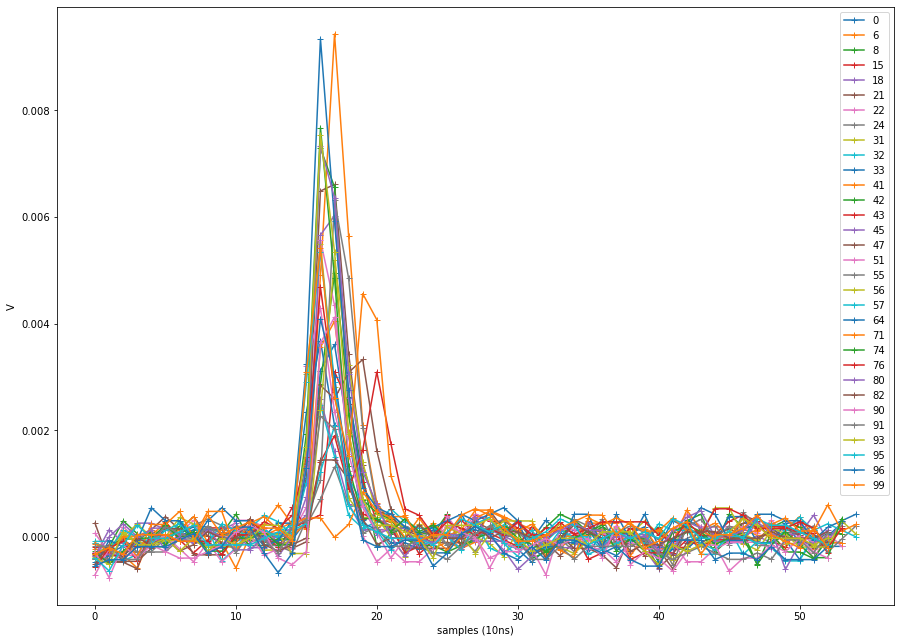

In [3]:
for i in range(100):
    if QDict['evMask'][i] and QDict['qData'][i]>0.5:  
        plt.plot(QDict['waves'][i][QDict['trgT'][i]:],marker='+',label=i)
plt.xlabel('samples (10ns)')
plt.ylabel('V')
plt.legend()
plt.show()

In [25]:
def LoGkernel(sigma=1,scale=5,norm=False):
    sigma2 = sigma*sigma
    size = int(scale*sigma)
    x = (np.arange(size) - (size-1)/2.0)
    kernel = (x*x/sigma2 - 1)/sigma2
    N = 1/(sigma*np.sqrt(2*np.pi)) if norm else 1
    x2 = N*np.exp(-x*x/(2*sigma2))
    print(x)
    print(kernel)
    LoG = kernel*x2
    return LoG
def mycorrelate(kernel,arr):
    np.correlate(arr,kernel,mode="full")

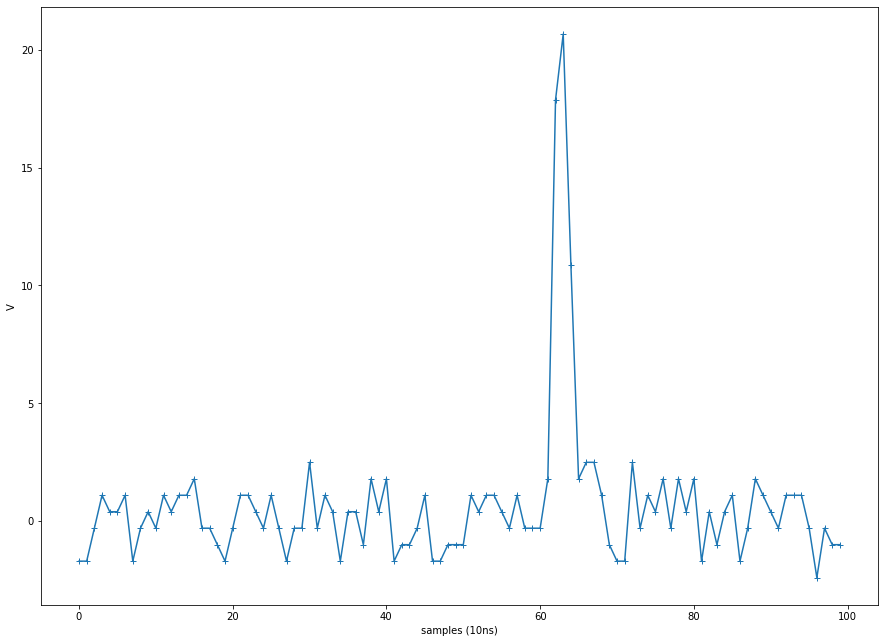

In [5]:
testEv = QDict['waves'][0]/QDict['baserms'][0]
plt.plot(testEv,marker='+')
plt.xlabel('samples (10ns)')
plt.ylabel('V')
plt.show()

In [6]:
ksize = 20
ksigma = 3
scale = 6
kernel = LoGkernel(ksigma,scale=scale)
print(kernel)

[-8.5 -7.5 -6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5
  5.5  6.5  7.5  8.5]
[ 0.7808642   0.58333333  0.41049383  0.26234568  0.13888889  0.04012346
 -0.03395062 -0.08333333 -0.10802469 -0.10802469 -0.08333333 -0.03395062
  0.04012346  0.13888889  0.26234568  0.41049383  0.58333333  0.7808642 ]
[ 0.01410476  0.02562988  0.03925735  0.04886725  0.04509062  0.02031594
 -0.02399115 -0.07354141 -0.10653472 -0.10653472 -0.07354141 -0.02399115
  0.02031594  0.04509062  0.04886725  0.03925735  0.02562988  0.01410476]


(100,)


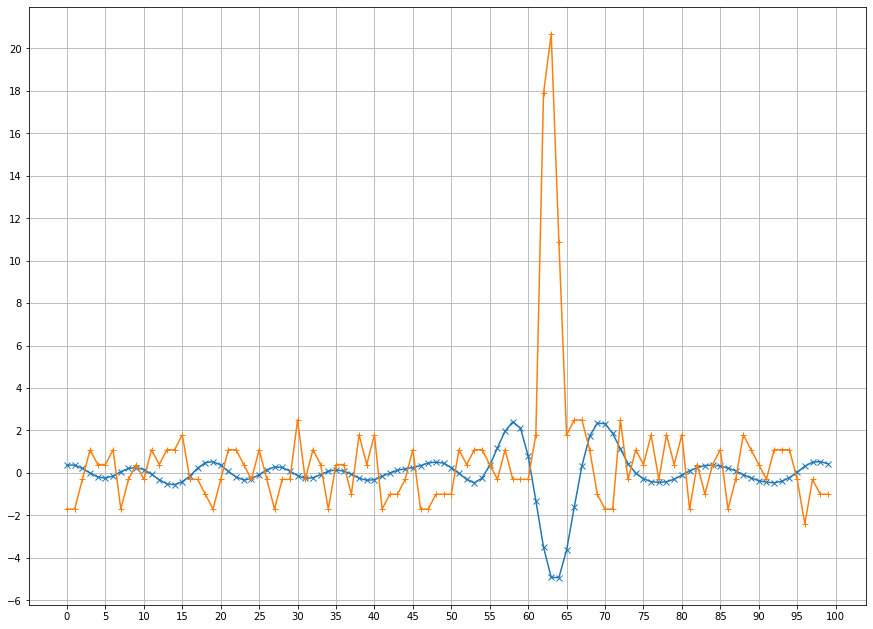

In [7]:
LoG = np.correlate(testEv,kernel,mode="full")[int(ksigma*scale/2)-1:-int(ksigma*scale/2)]
print(LoG.shape)
plt.plot(LoG,marker='x')
plt.plot(testEv,marker='+')
plt.gca().xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
plt.grid()

In [8]:
def mmg_rolling(a, window):
        axis =-1
        shape = a.shape[:axis] + (a.shape[axis] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        rolling = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
        grad = rolling[...,-1]-rolling[...,0]
        return np.max(rolling,axis=axis),np.min(rolling,axis=axis),grad/(window-1.0)

In [9]:
def zero_crossing(mLoG,thresh,window=3):
    maxL,minL,gradL = mmg_rolling(mLoG,window)
    pzero = (mLoG[...,1:-1]>0)
    zeroCross = np.zeros(shape=mLoG.shape).astype(np.int)
    zeroCross[...,1:-1] = pzero*(minL<0) + (1-pzero)*(maxL>0)
    diffL = maxL-minL
    zeroCross[...,1:-1] = zeroCross[...,1:-1]*(diffL > thresh)
    zeroCross[...,1:-1] = ((gradL>thresh/window).astype(np.int)-(gradL<-thresh/window).astype(np.int))*zeroCross[...,1:-1]
    return zeroCross,np.array(np.nonzero(zeroCross))

th = 3.5
zeroCross=zero_crossing(LoG,th)
zeroCross

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  1,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([[61, 66]]))

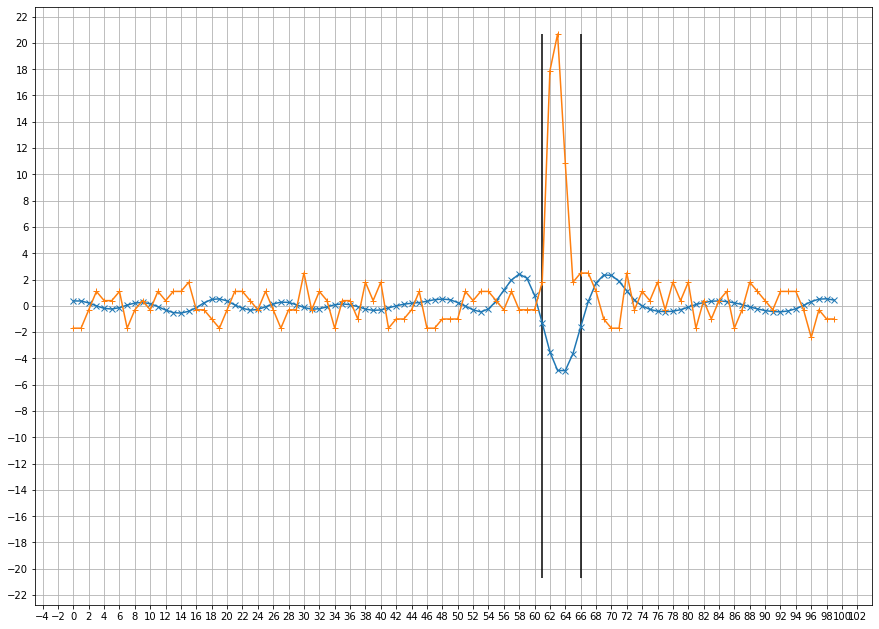

In [10]:
plt.plot(LoG,marker='x')
plt.plot(testEv,marker='+')
plt.vlines(zeroCross[1][0],-testEv.max(),testEv.max())
plt.gca().xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
plt.grid()

In [11]:
cumzeros = np.cumsum(zeroCross[0],axis=-1)
cumzeros

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [12]:
badedges = 1 - (cumzeros<-1).astype(np.int)
ncumzeros = np.cumsum(zeroCross[0]*badedges,axis=-1)
ncumzeros

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

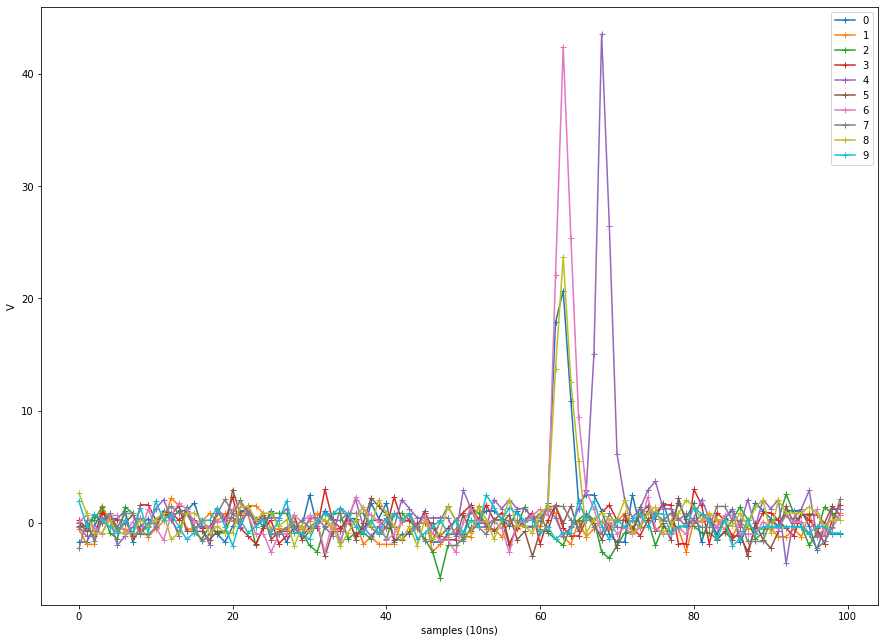

In [13]:
testEv2 = QDict['waves'][0:100]/QDict['baserms'][0:100,np.newaxis]
for i in range(10):
    plt.plot(testEv2[i],marker='+',label=i)
plt.xlabel('samples (10ns)')
plt.ylabel('V')
plt.legend()
plt.show()

In [31]:
from scipy import signal

ksigma = 3
scale = 5
ksize = ksigma*scale
Lkernel = LoGkernel(ksigma,scale=scale)
LoGL = signal.fftconvolve(testEv2,Lkernel[np.newaxis,...],mode='full',axes=1)[:,int(ksize/2):-int(ksize/2)]

[-7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.]
[ 0.49382716  0.33333333  0.19753086  0.08641975  0.         -0.0617284
 -0.09876543 -0.11111111 -0.09876543 -0.0617284   0.          0.08641975
  0.19753086  0.33333333  0.49382716]


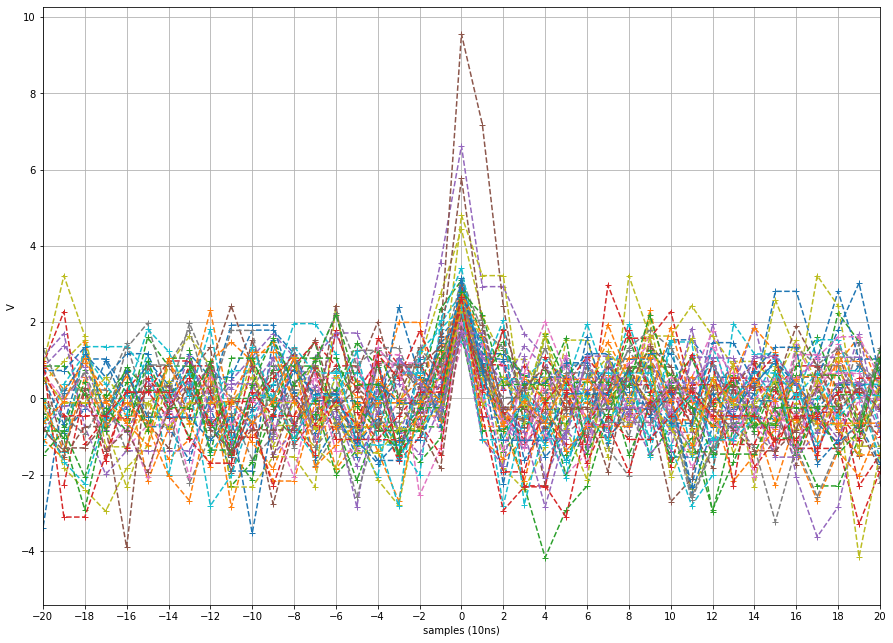

In [46]:
for i in range(100):
    if int(LoGL[i].max())<0.5:
        x=np.arange(100)-np.argmax(testEv2[i])
        p=plt.plot(x,testEv2[i],marker='+',label=i,linestyle='dashed')
        #plt.plot(x,LoGL[i]*scale,marker='x',label='{}LoG'.format(i),color=p[-1].get_color())
        #plt.plot(x,LoGL[i]*scale,marker='x',label='{}LoGR'.format(i))
plt.xlabel('samples (10ns)')
plt.ylabel('V')
plt.gca().xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
plt.grid()
plt.xlim((-20,20))
#plt.legend()
plt.show()
#input('Cont...')

In [48]:
th = 1
zeroCross=zero_crossing(LoGL,th)
zeroCross

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[ 0,  0,  0,  0,  0,  2,  2,  2,  4,  4,  4,  4,  4,  4,  6,  6,
          6,  6,  6,  6,  8,  8,  8,  8,  8, 15, 15, 15, 15, 15, 15, 16,
         16, 16, 16, 16, 16, 18, 18, 18, 18, 21, 21, 21, 21, 21, 21, 21,
         22, 22, 22, 22, 22, 22, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26,
         26, 26, 26, 26, 29, 29, 29, 29, 30, 31, 31, 31, 31, 31, 32, 32,
         32, 32, 33, 33, 33, 33, 33, 33, 34, 34, 37, 37, 37, 37, 37, 38,
         41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 43, 43, 43, 43, 45,
         45, 45, 45, 45, 45, 46, 46, 47, 47, 47, 47, 47, 47, 49, 51, 51,
         51, 51, 51, 51, 53, 53, 53, 53, 53, 53, 54, 55, 55, 55, 55, 55,
         55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 58,
         61, 61, 61, 63, 63, 63, 64, 64, 64, 64, 64, 64, 

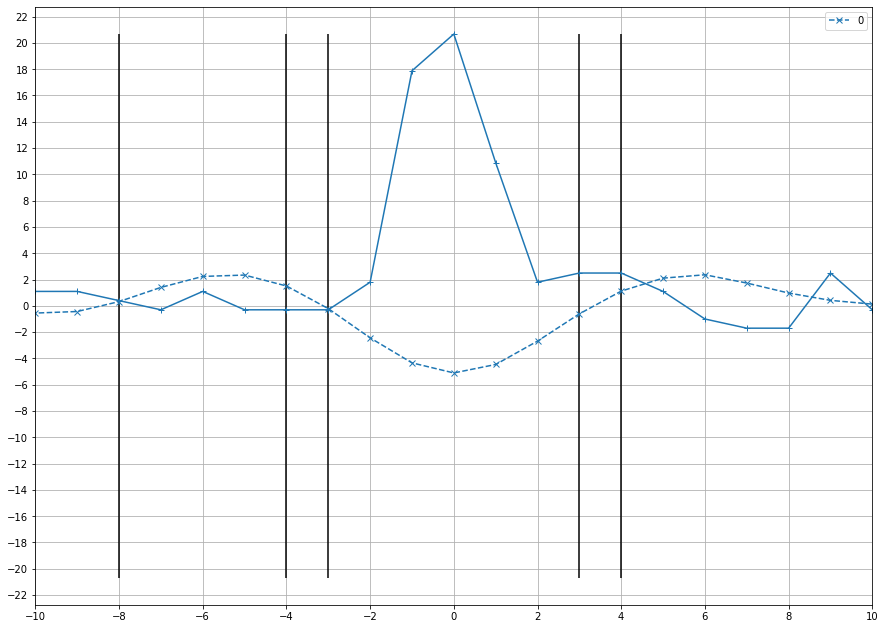

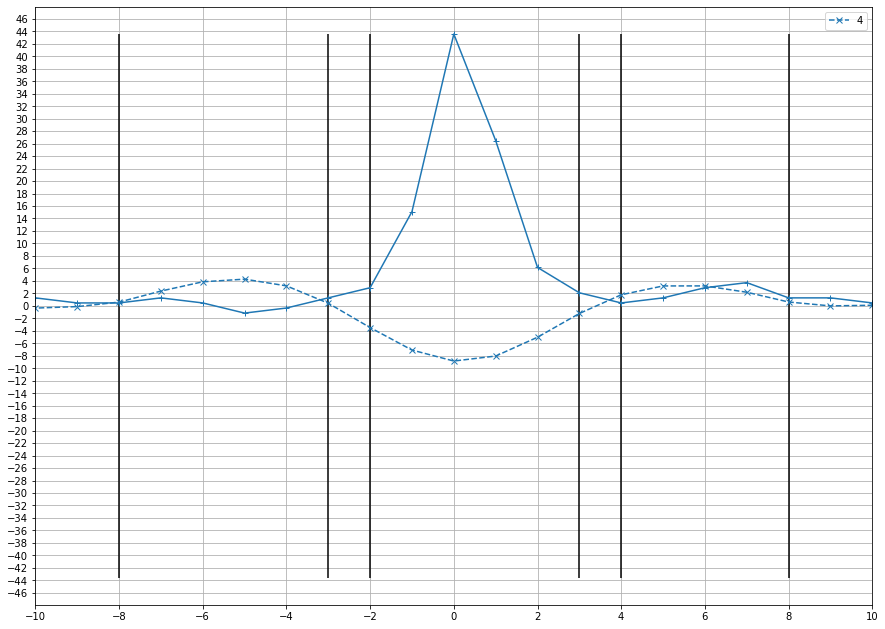

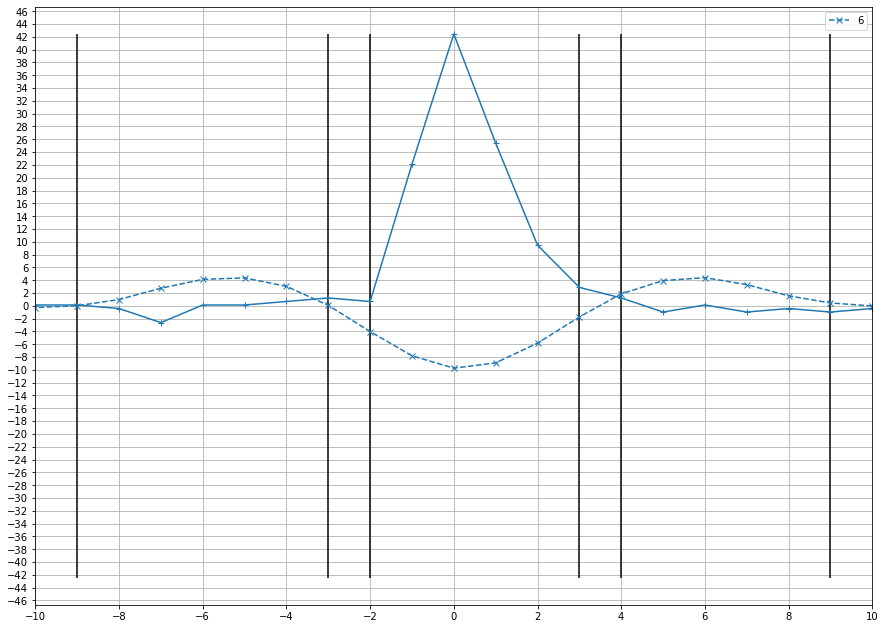

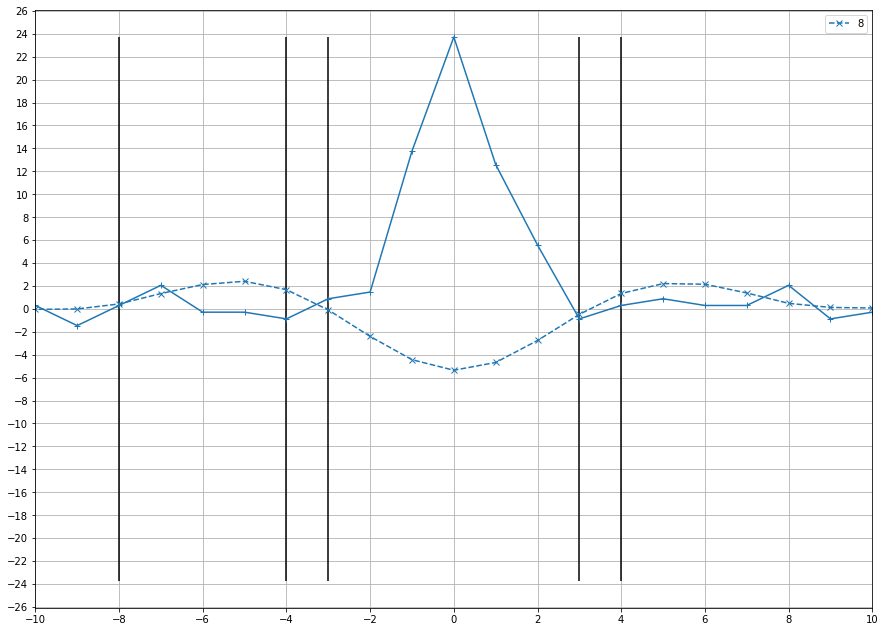

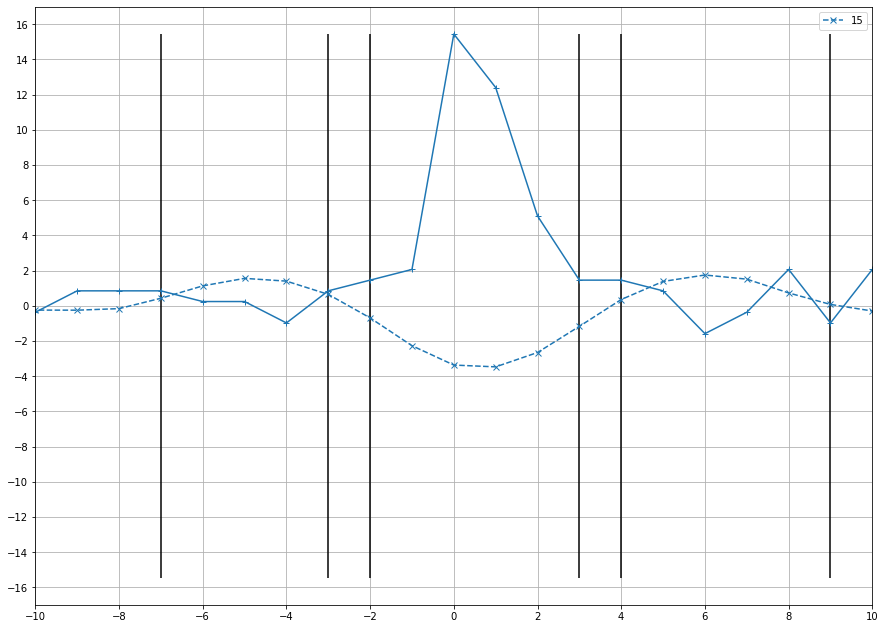

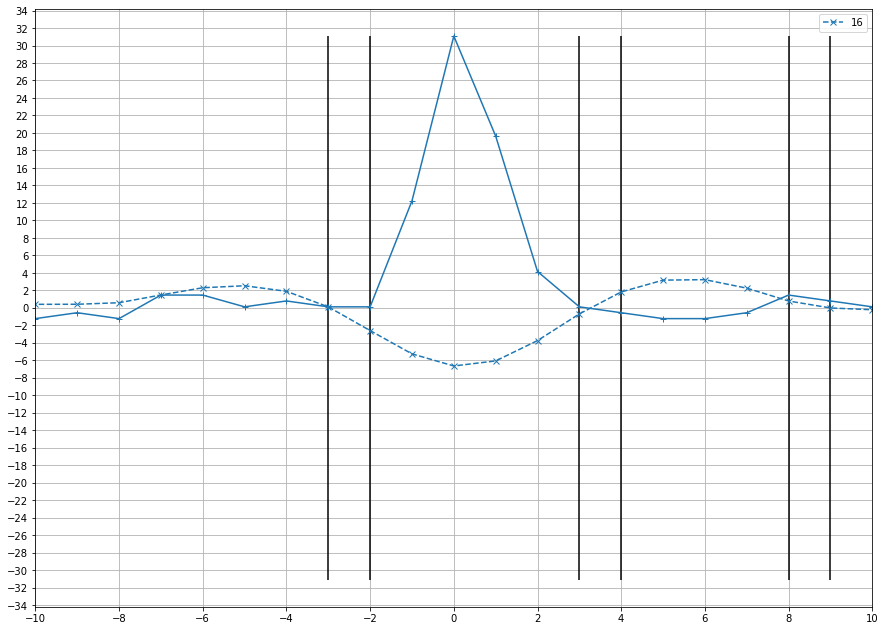

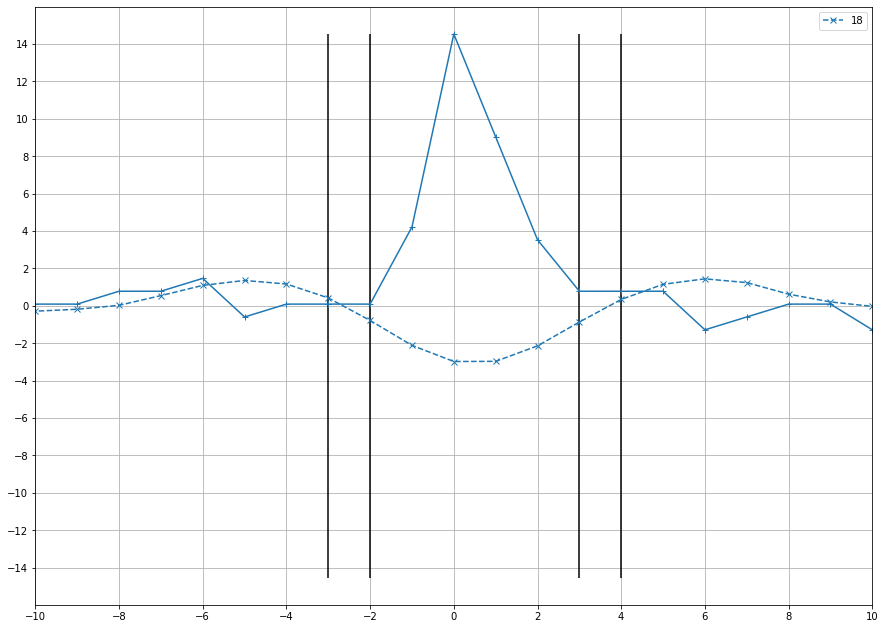

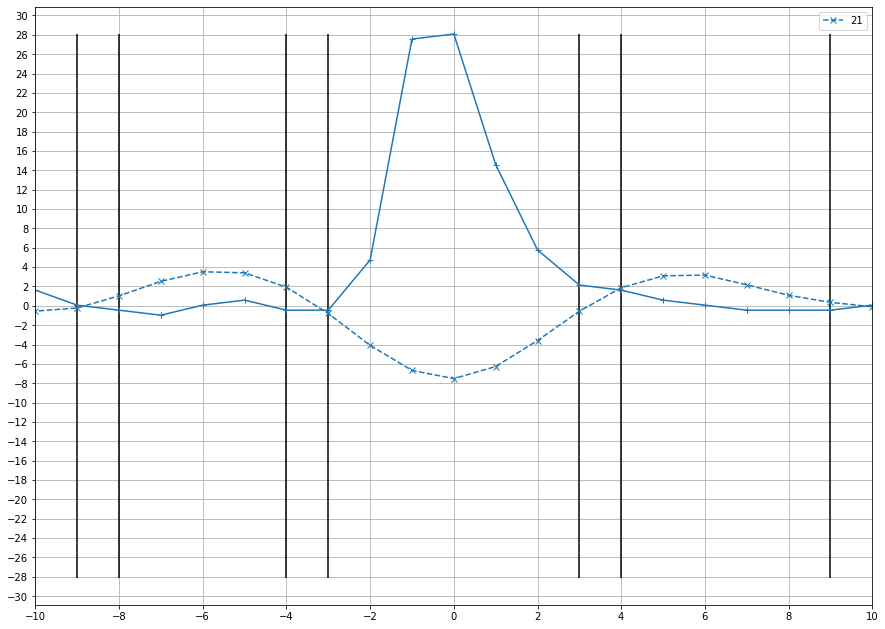

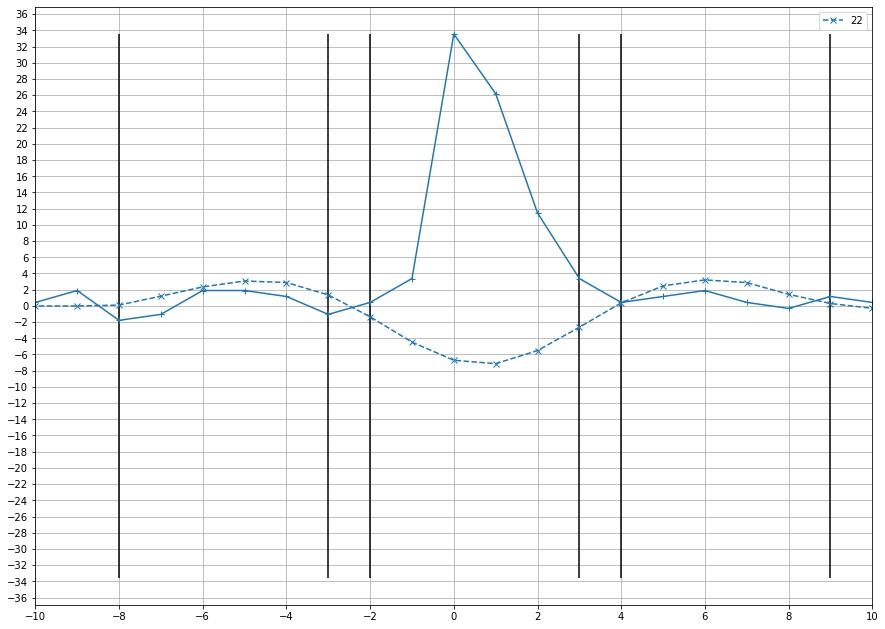

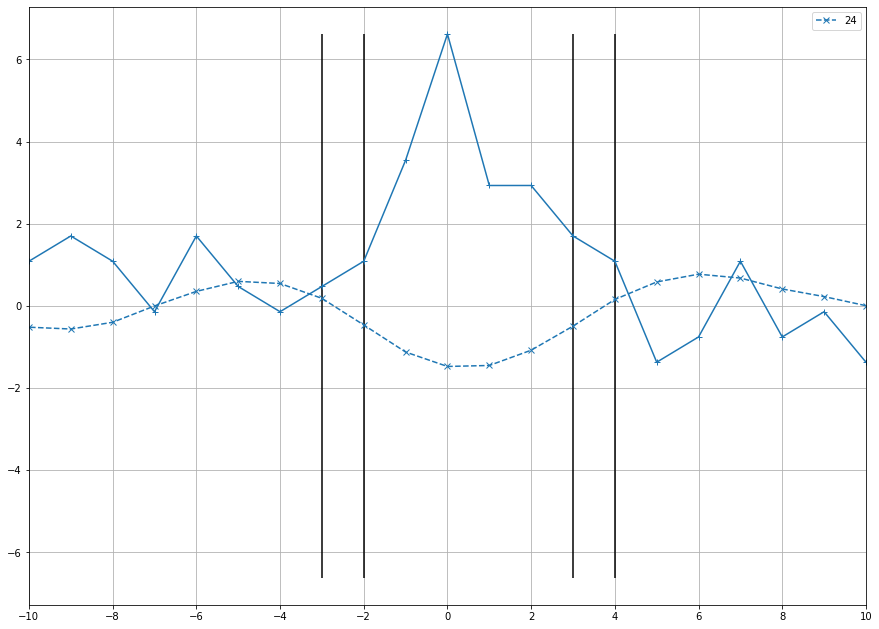

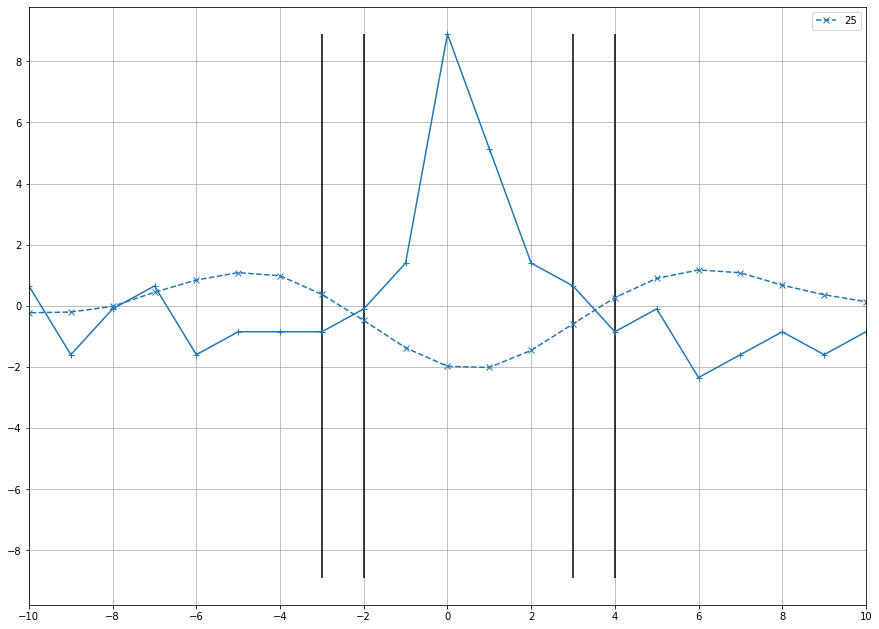

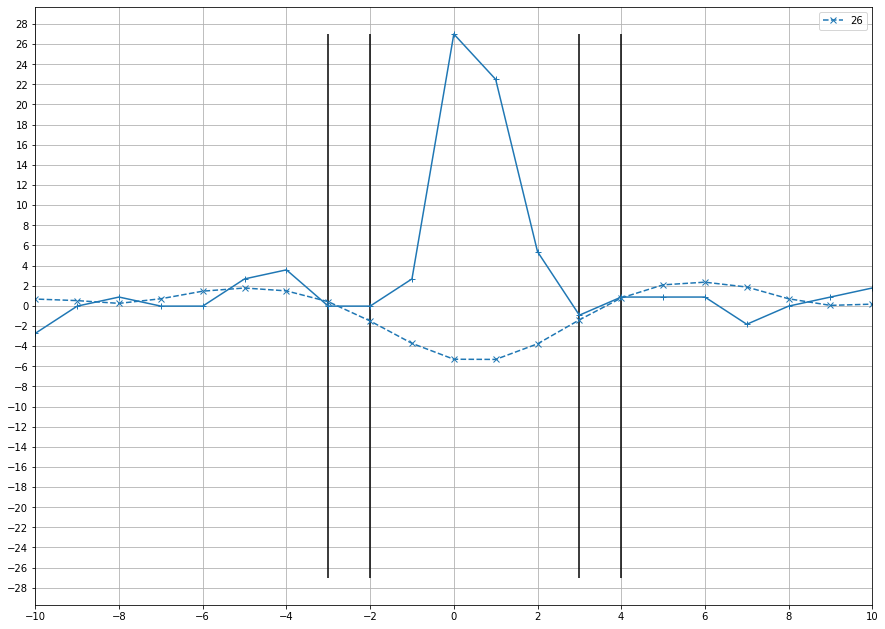

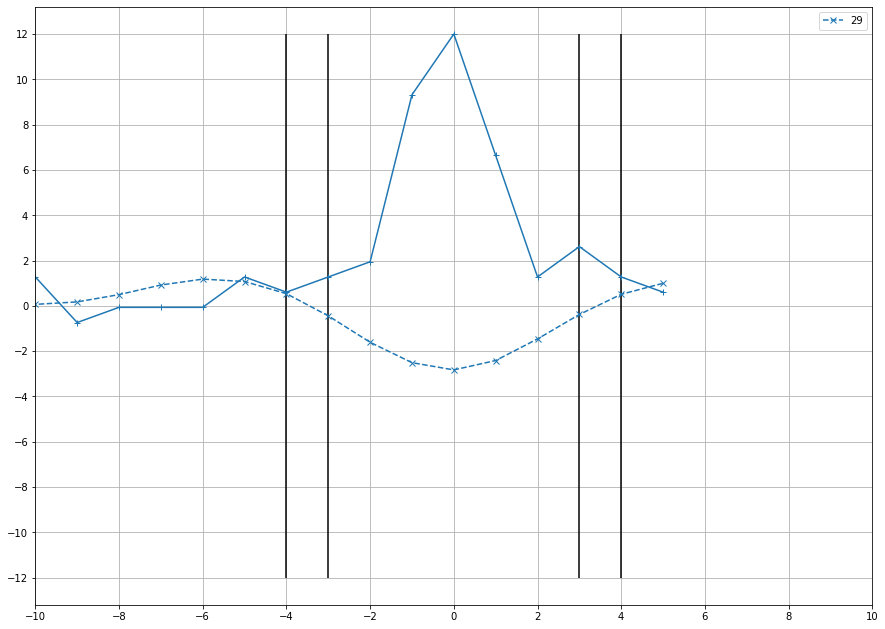

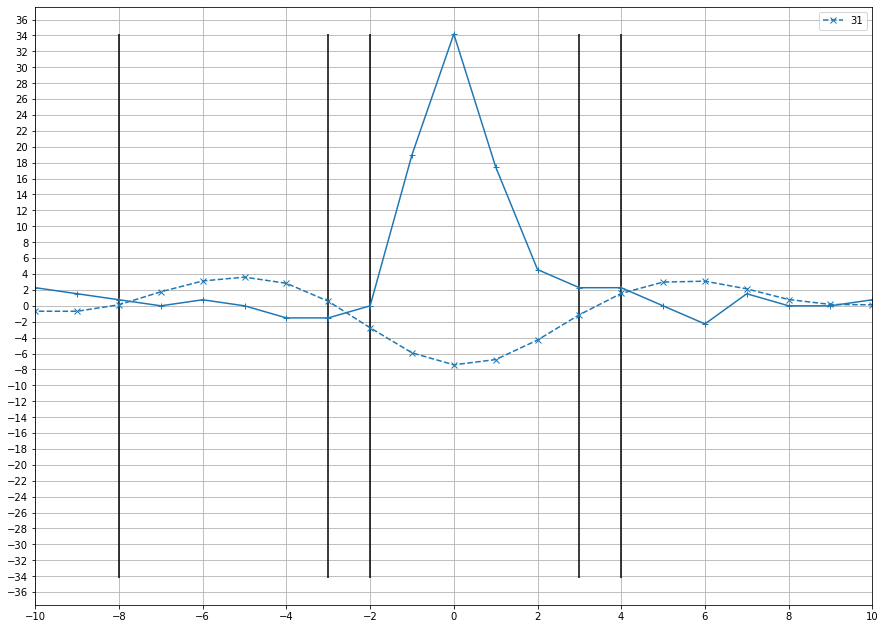

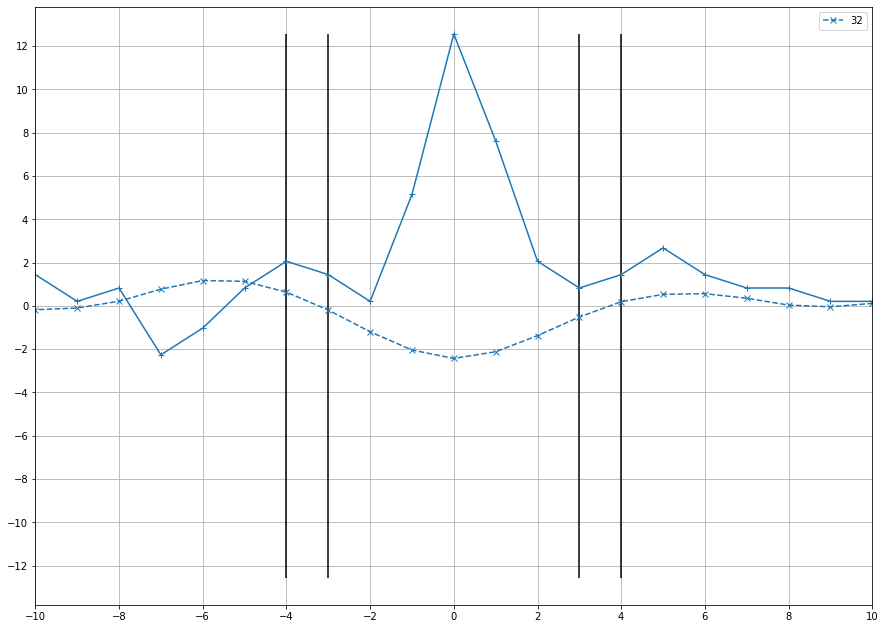

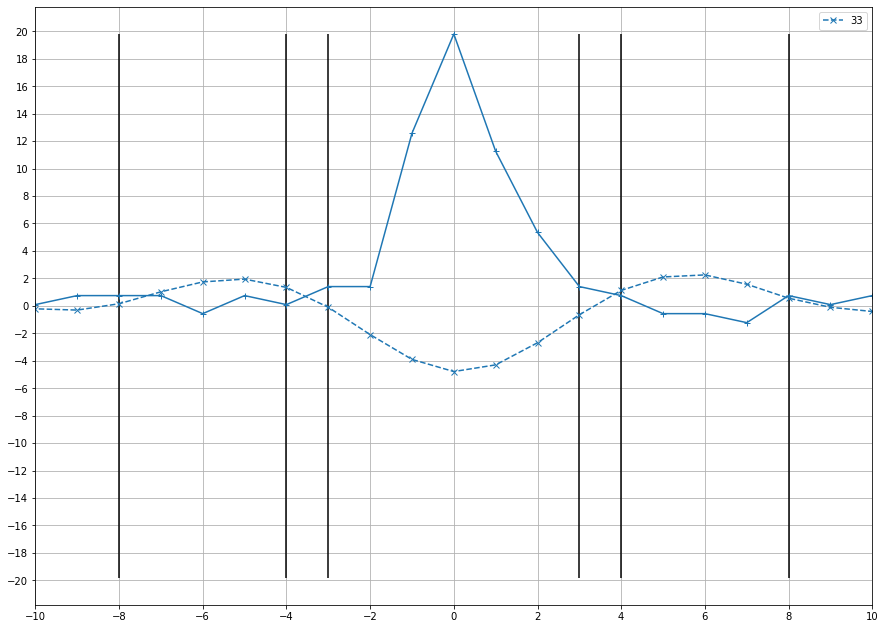

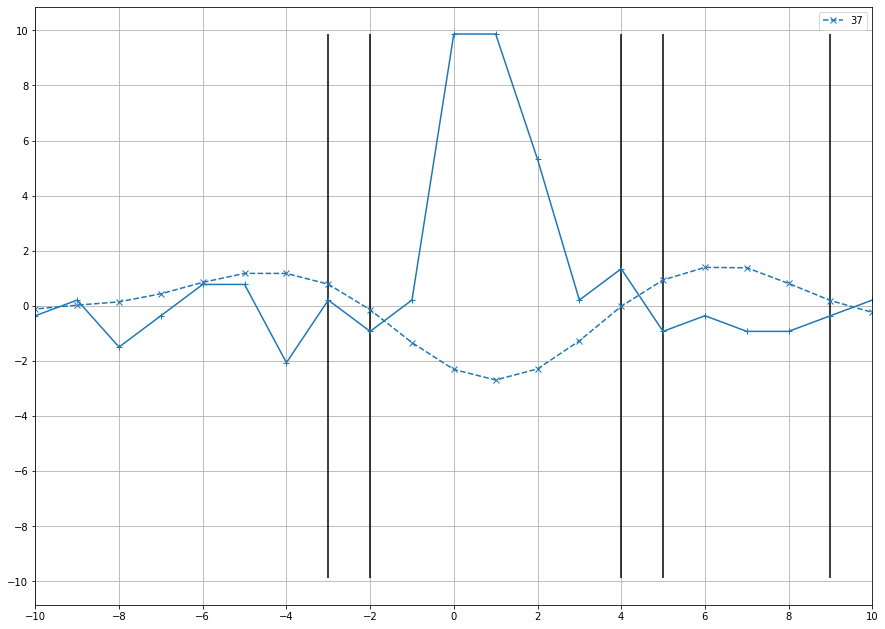

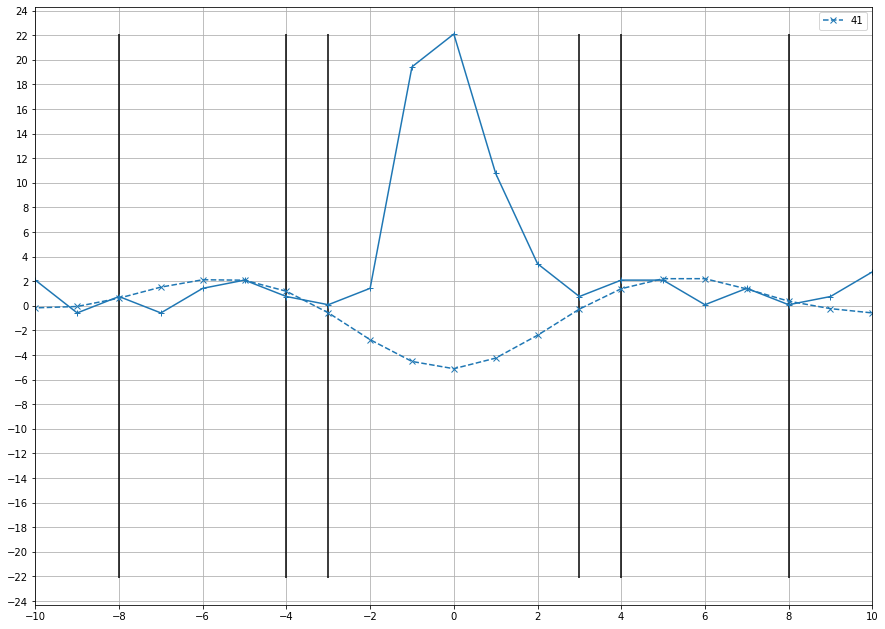

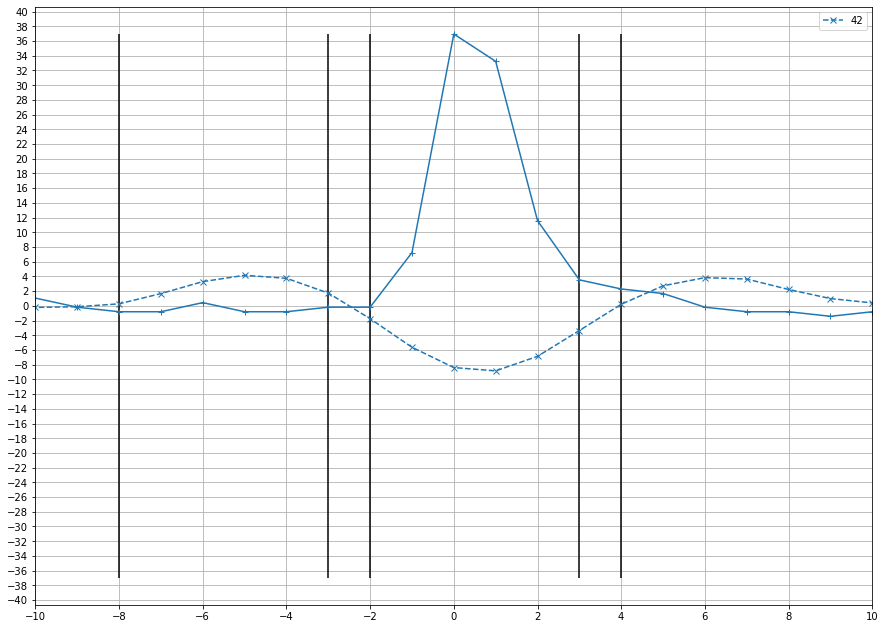

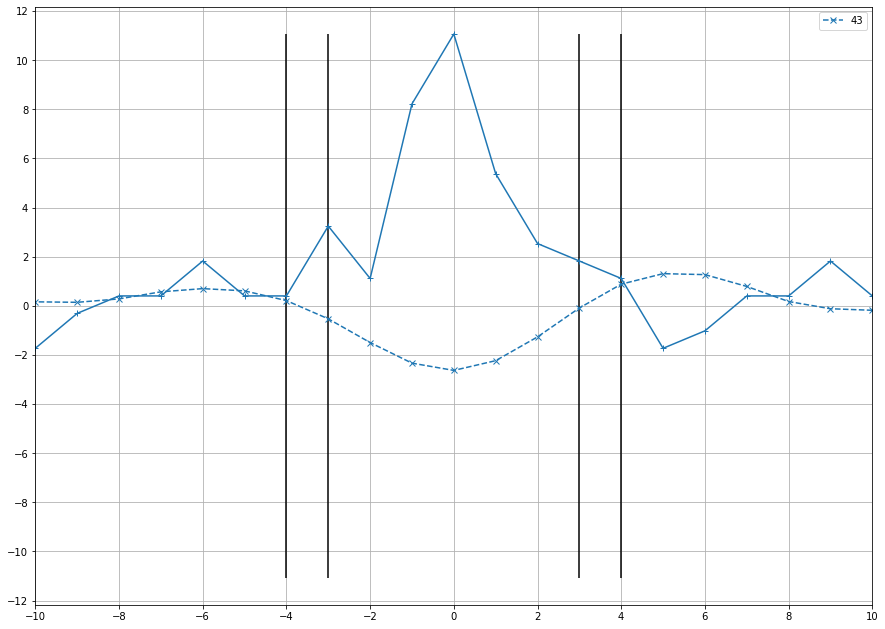

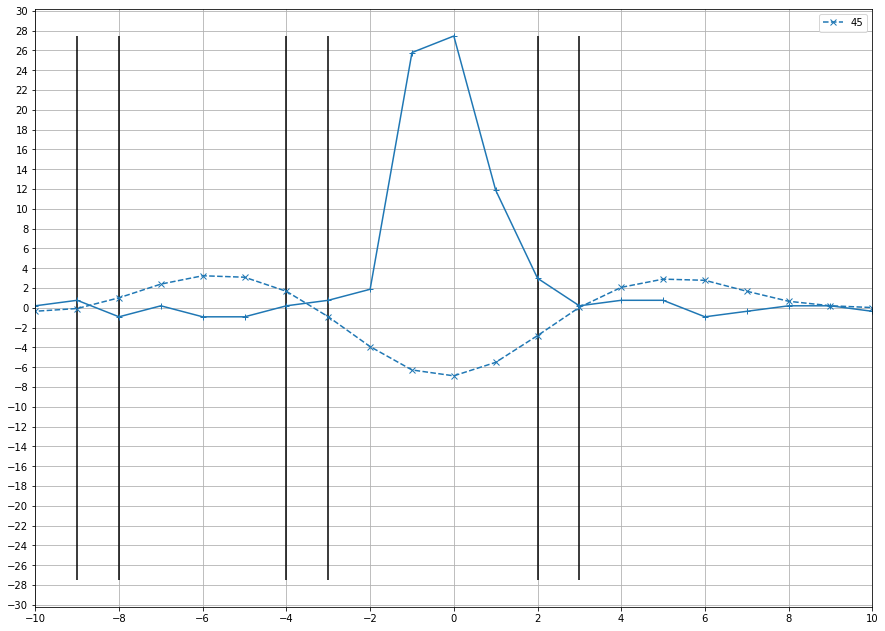

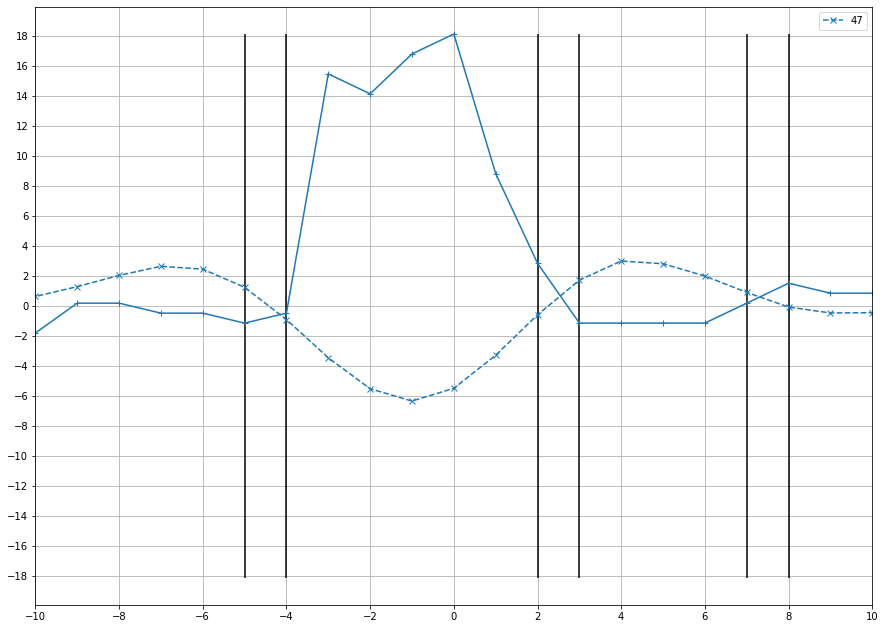

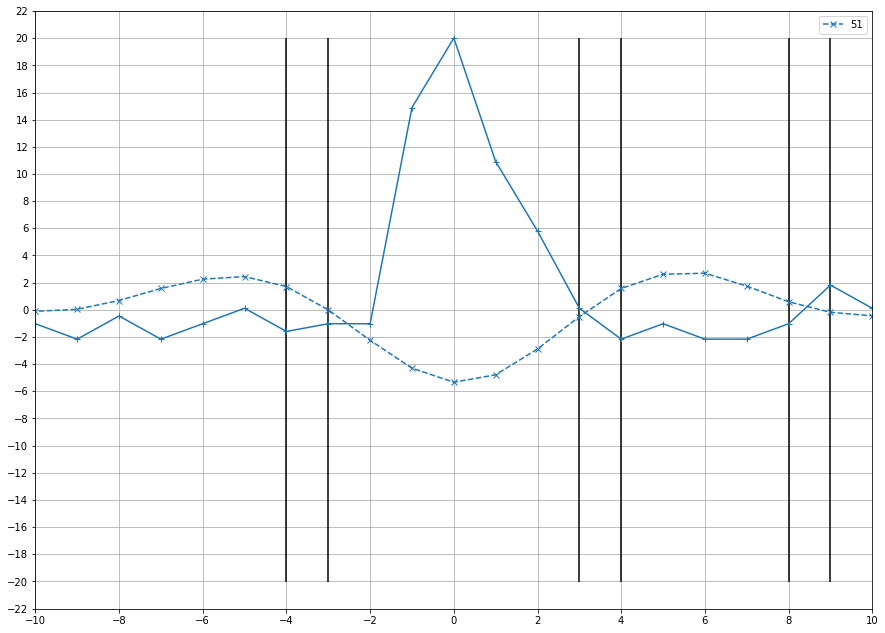

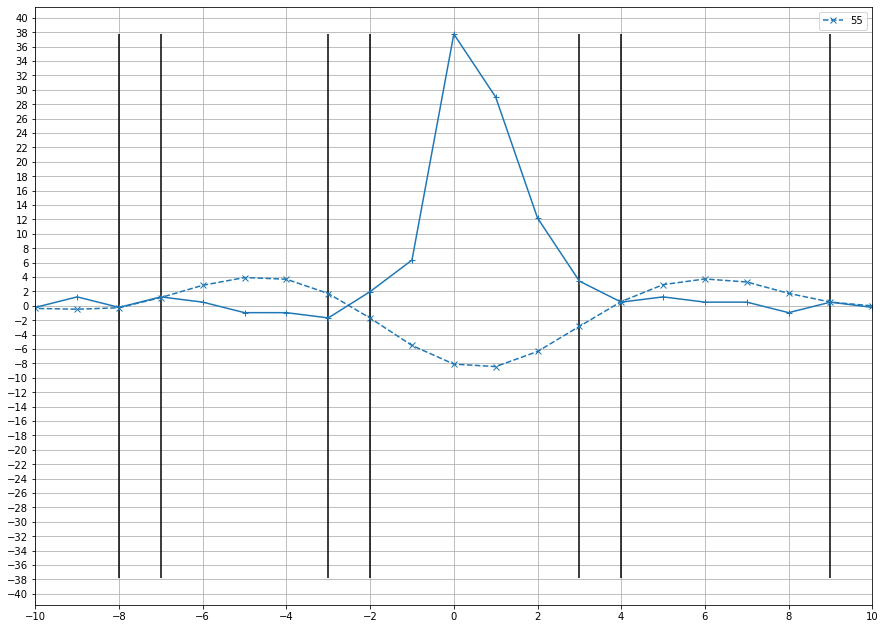

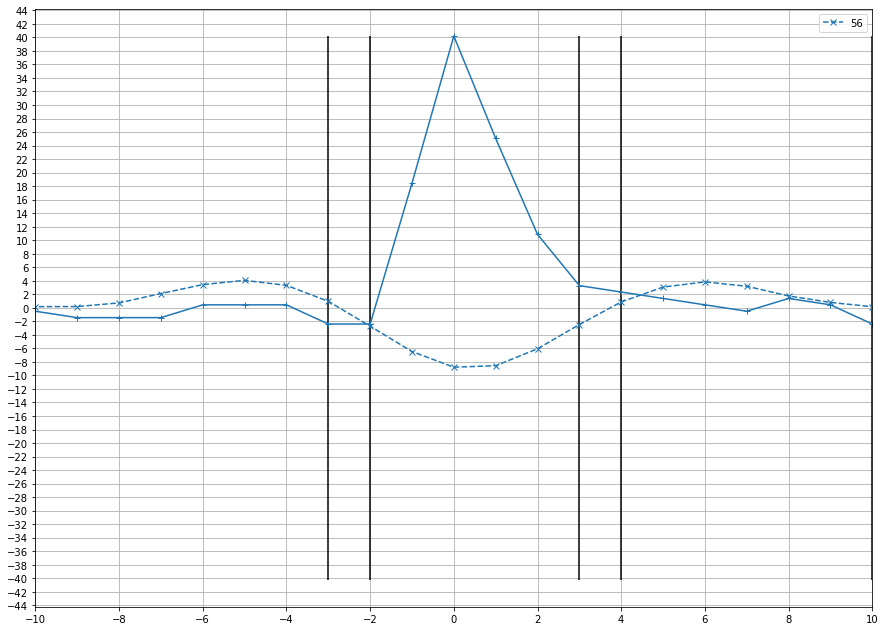

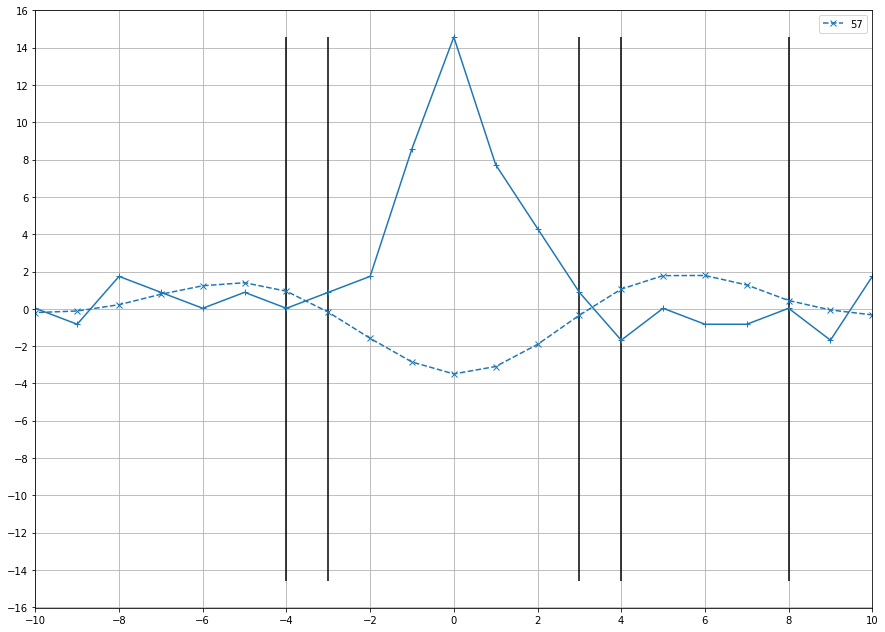

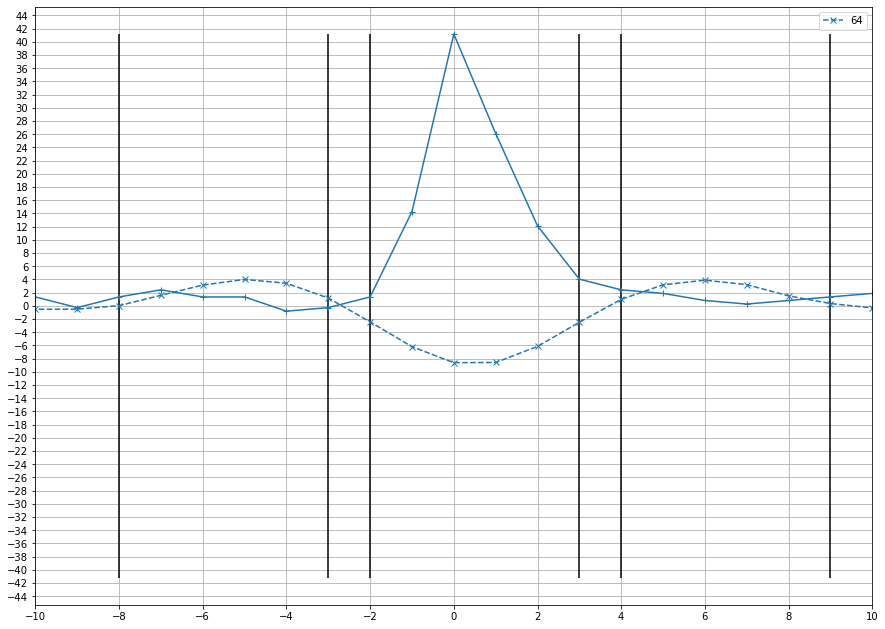

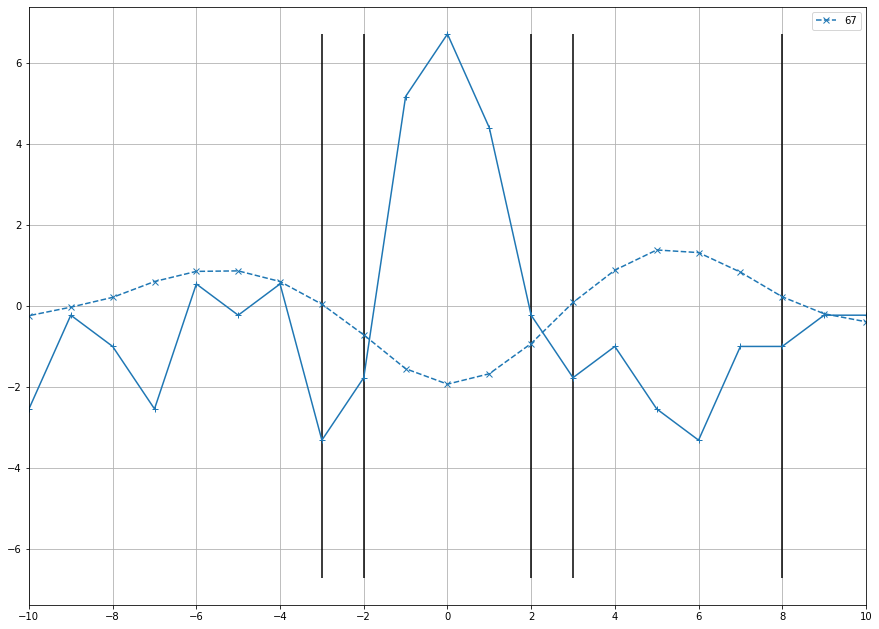

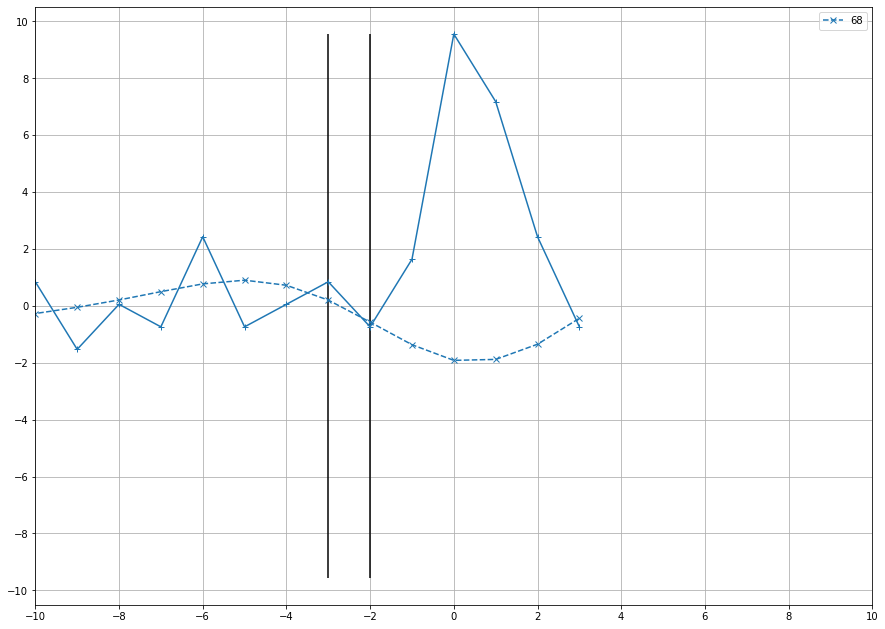

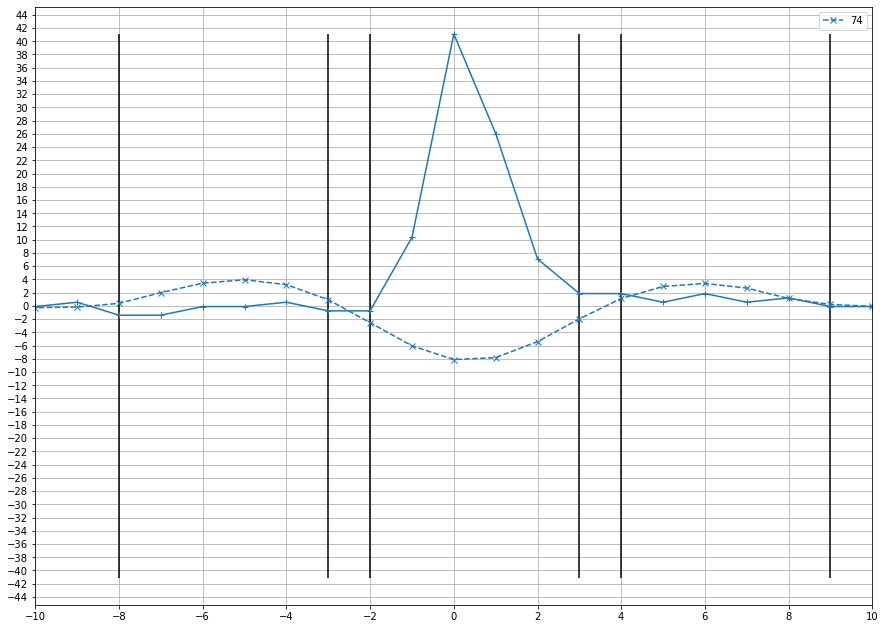

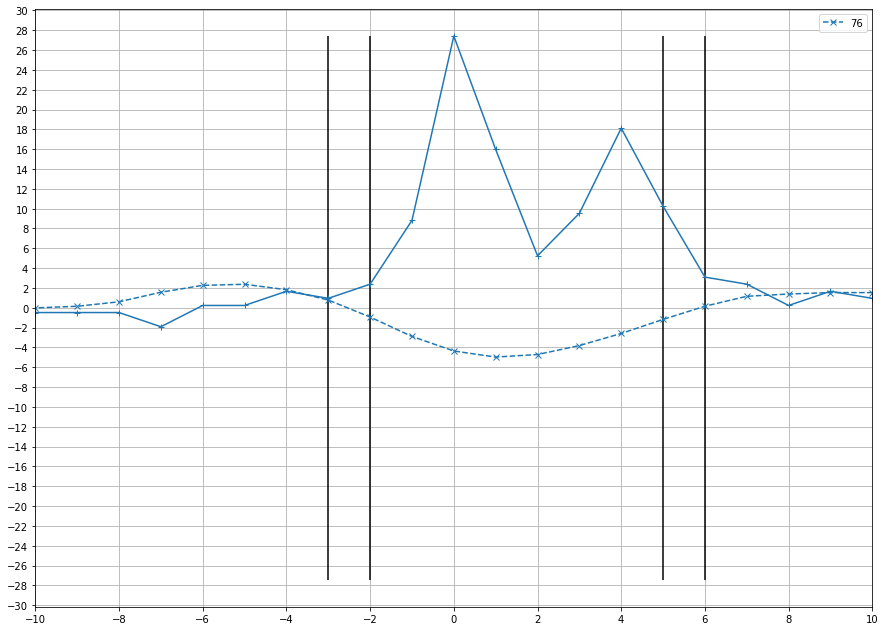

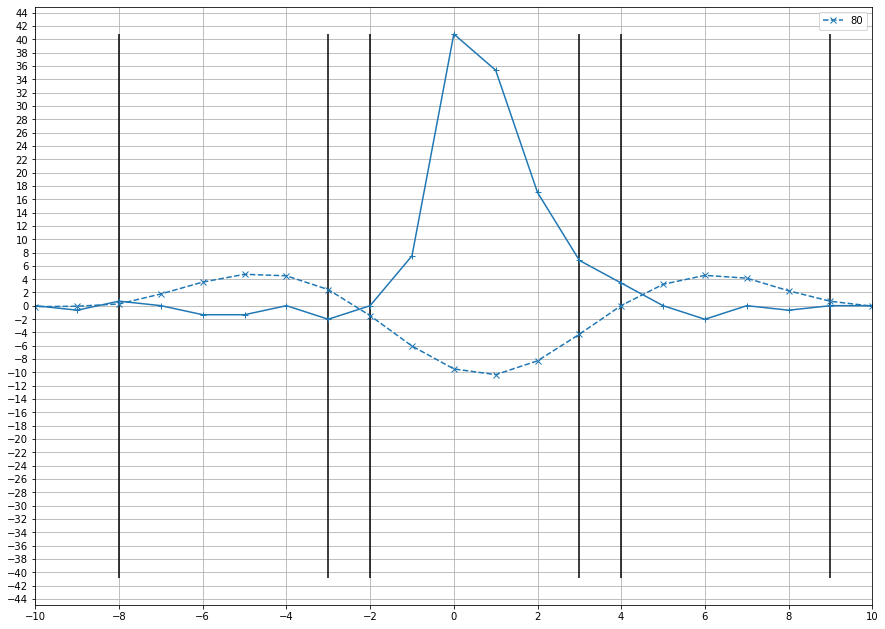

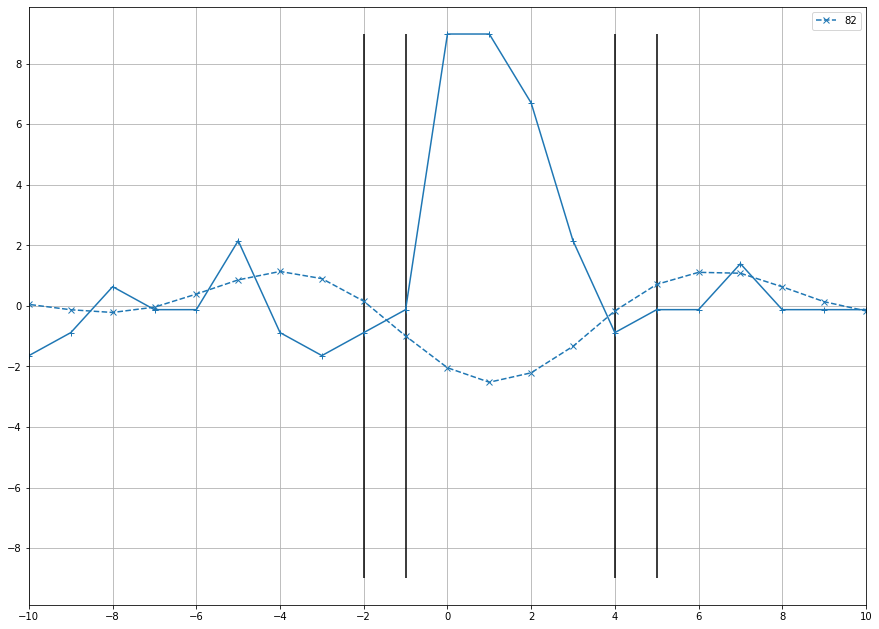

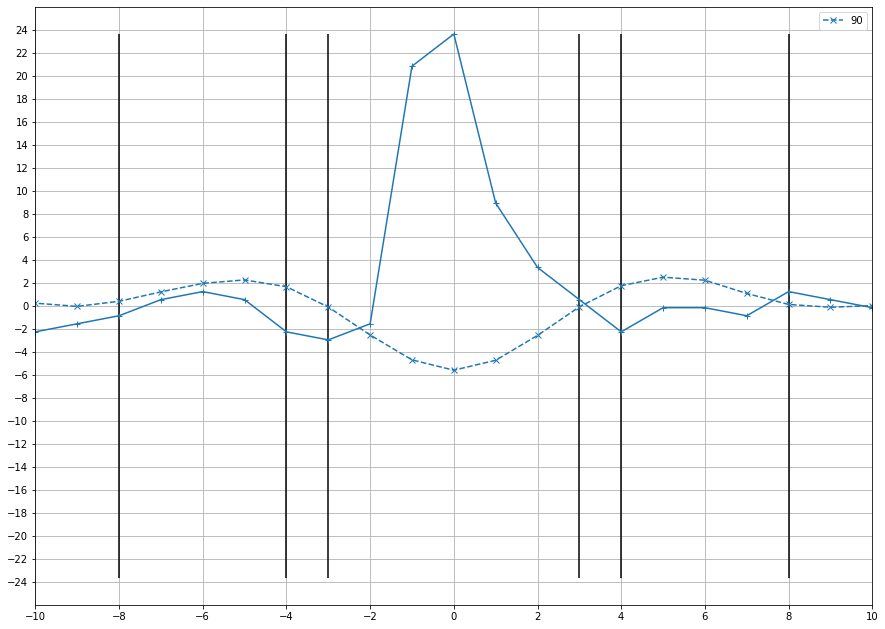

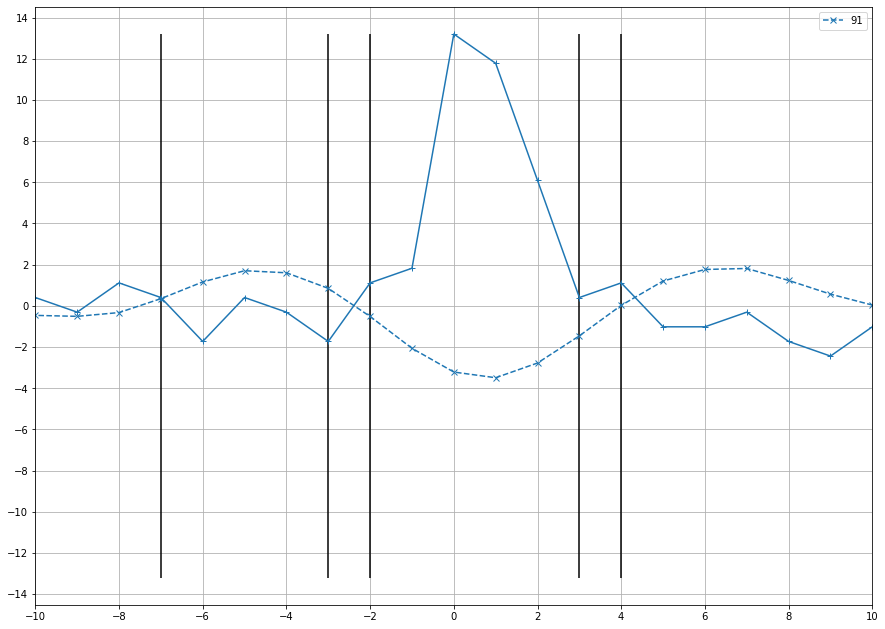

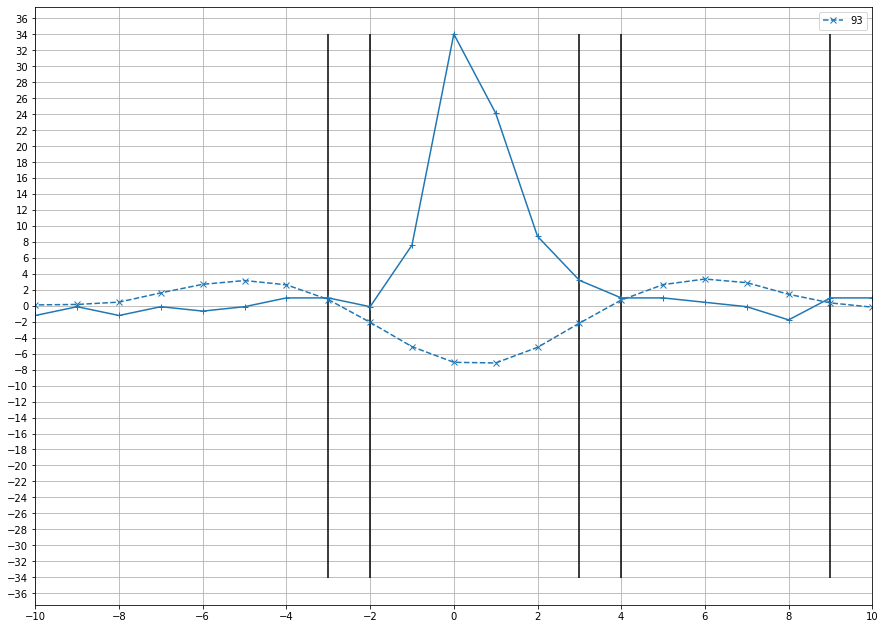

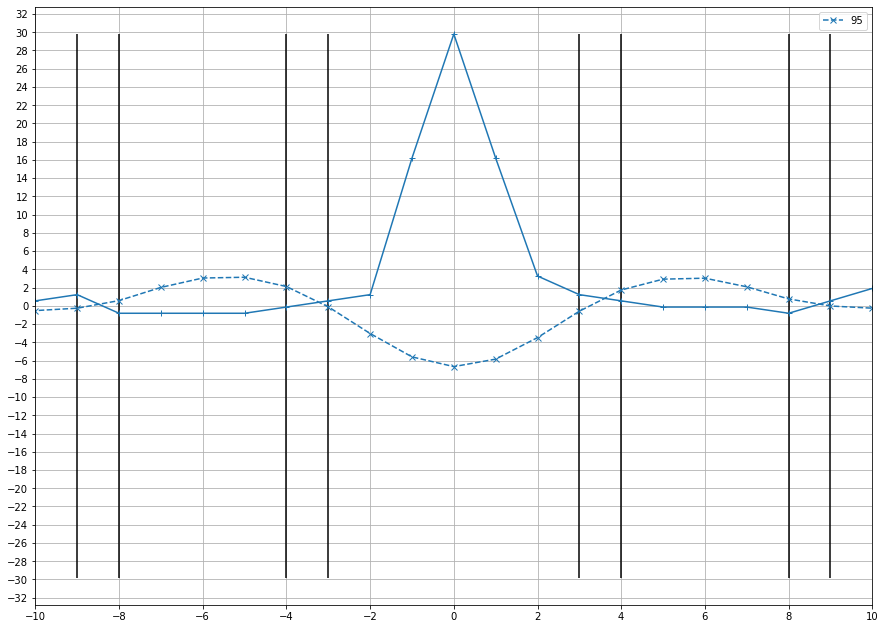

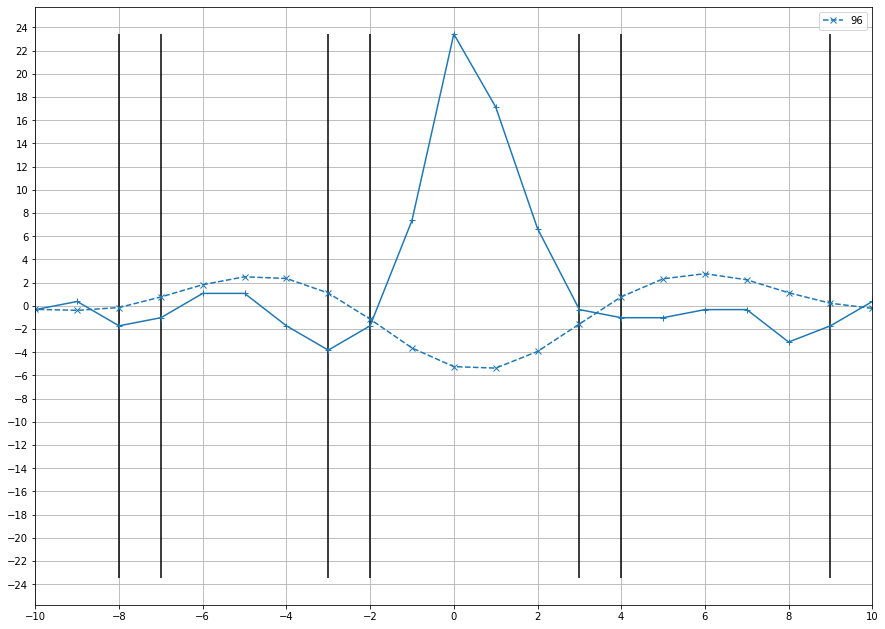

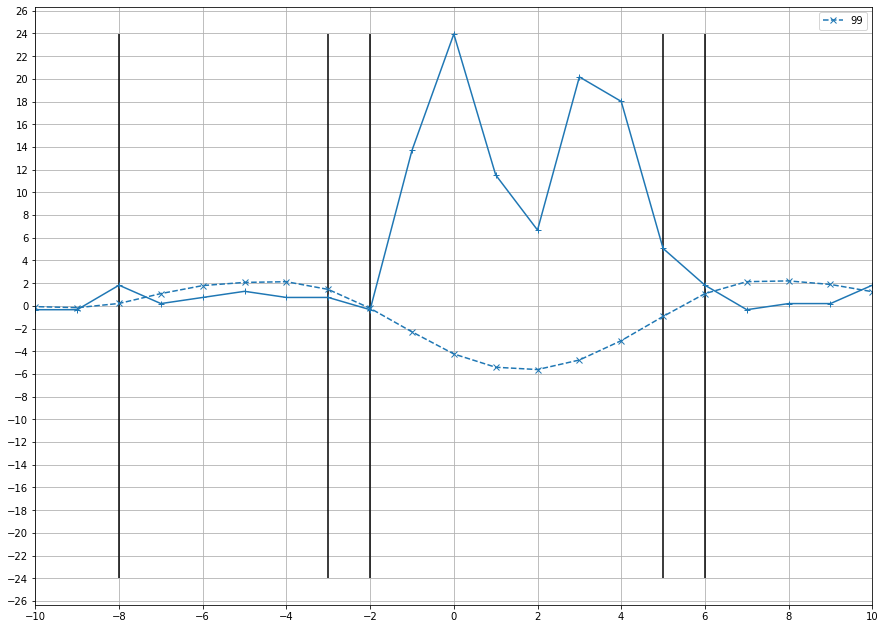

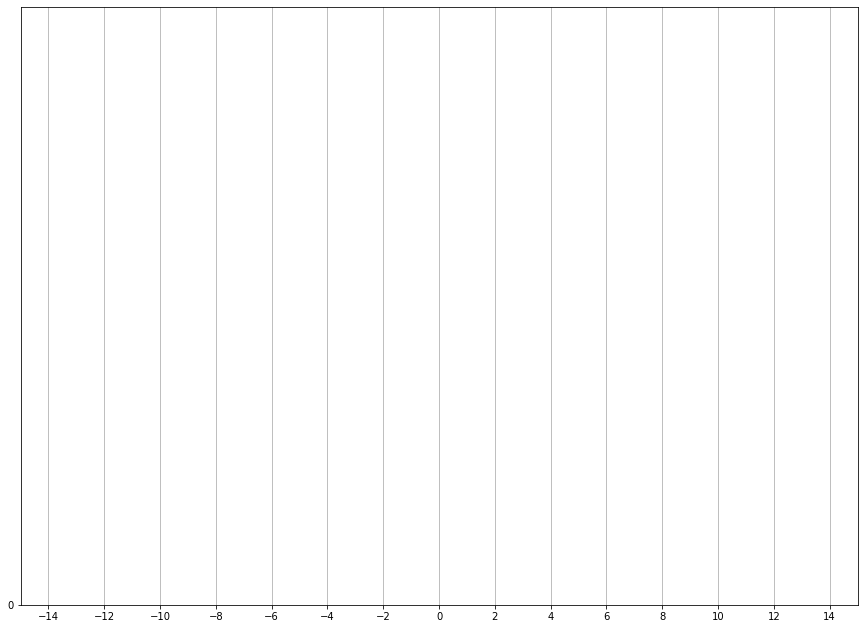

In [49]:
cols=np.empty(100,dtype=object)
for i in range(100):
    if int(testEv2[i].max())>5:
        x=np.arange(100)-np.argmax(testEv2[i])
        p=plt.plot(x,LoGL[i],marker='x',label=i,linestyle='dashed')
        cols[i]=p[-1].get_color()
        plt.plot(x,testEv2[i],marker='+',color=cols[i])
        plt.vlines(np.nonzero(zeroCross[0][i])[0]-np.argmax(testEv2[i]),-testEv2[i].max(),testEv2[i].max())
        plt.gca().xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
        plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
        plt.grid()
        plt.xlim((-10,10))
        plt.legend()
        plt.show()
        #input('Cont...')
#plt.vlines(zeroCross[1][-1]-np.argmax(testEv2,axis=-1)[zeroCross[1][0]],-np.amax(testEv2,axis=-1)[zeroCross[1][0]],np.argmax(testEv2,axis=-1)[zeroCross[1][0]],colors=cols[zeroCross[1][0]])
plt.gca().xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
plt.grid()
plt.xlim((-15,15))
plt.show()